In [ ]:
!pip --quiet install pytorch_spiking

In [ ]:
import os, torch, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import TransformerEncoder, TransformerEncoderLayer, LayerNorm
from torch import nn
import matplotlib.pyplot as plt
import random
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device='cuda'

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

def prepare_data_x(data, window_size, lag):
    # perform windowing
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([1, window_size, len(subset_mean)])
    x_mean = np.zeros([1, len(subset_mean)])
    x_std = np.zeros([1, len(subset_mean)])
    for idx in range(1):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    return output

def prepare_data_y(x, window_size, lag, delay):
    output = np.zeros([1,1,1])
    x = x.values
    std = 1.1*np.sqrt(lag)+lag*0.01
    future_price = x[window_size+lag-1,0]
    future_ask = x[window_size+lag-1,20]
    future_bid = x[window_size+lag-1,2]
    current_price = x[window_size+delay-1, 0]
    delayed_ask = x[window_size+delay-1, 20]
    delayed_bid = x[window_size+delay-1, 2]
    logreturn = np.log(future_price/current_price)*10_000
    output[0,0,0] = logreturn
    return output, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask

def prepare_data(normalized_prices_train, delay, lag=1):
    data_x = prepare_data_x(normalized_prices_train, window_size=100, lag=lag)
    data_y, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask = prepare_data_y(normalized_prices_train, window_size=100, lag=lag, delay=delay)
    return data_x, data_y, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask


In [ ]:
class CustomTransformerDecoder(nn.Module):
    def __init__(self, n_time_series, seq_len, output_seq_len, d_model=128,
                 n_heads=8, n_layers_encoder=6, dropout=0.1, output_dim=1, forward_dim=2048,
                 use_mask=False):
        super(CustomTransformerDecoder, self).__init__()
        self.n_time_series = n_time_series
        self.d_model = d_model
        self.nheads = n_heads
        self.forward_dim = forward_dim
        self.dropout = dropout
        self.n_layers_encoder = n_layers_encoder
        self.output_dim = output_dim 
        self.seq_len = seq_len
        self.output_seq_len = output_seq_len
        self.mask_it = use_mask

        self.dense_shape = nn.Linear(self.n_time_series, self.d_model)
        self.encoder_layer = TransformerEncoderLayer(self.d_model, self.nheads, self.forward_dim, self.dropout, activation=pytorch_spiking.SpikingActivation(nn.PReLU()))
        self.encoder_norm = LayerNorm(self.d_model)
        self.transformer_enc = TransformerEncoder(self.encoder_layer, self.n_layers_encoder, self.encoder_norm)
        self.output_dim_layer = nn.Linear(self.d_model, self.output_dim)
        self.out_length_lay = nn.Linear(self.seq_len, self.output_seq_len)
        self.mask = generate_square_subsequent_mask(self.seq_len).to(device)
        self.activation = nn.PReLU()
    
    def make_embedding(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        return x


    def forward(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.activation(x)
        x = self.out_length_lay(x)
        if self.output_dim > 1:
            return x.permute(0, 2, 1)
        return x.view(-1, self.output_seq_len)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


class LSTM_MO(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.prelu = nn.PReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()


    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


    def forward(self, x):
        batchsize = x.shape[0]

        x = self.linear_1(x)
        x = self.prelu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


    def train_model(self, train_dataloader, val_dataloader, learning_rate, scheduler_step_size, n_epochs=50, device="cpu", save_path=None, forecast_window=None):
      
        def run_epoch(dataloader, is_training=False):
            epoch_loss = 0
            outputs = torch.Tensor(0).to(device)
            targets = torch.Tensor(0).to(device)
            if is_training:
                self.train()
            else:
                self.eval()
            for idx, (x, y) in enumerate(dataloader):
                if is_training:
                    optimizer.zero_grad()

                batchsize = x.shape[0]
                x = x.to(device)
                y = y.to(device)
                out = self.forward(x)
                loss = criterion(out.contiguous(), y.contiguous())

                if is_training:
                    loss.backward()
                    optimizer.step()
                
                if not is_training:
                    outputs = torch.cat((outputs.contiguous(), out))
                    targets = torch.cat((targets, y.contiguous()))
                    
                epoch_loss += (loss.detach().item() / batchsize)
                
            lr = scheduler.get_last_lr()[0]
            if not is_training:
                print(outputs.cpu().detach().numpy())
                print(targets.cpu().detach().numpy())
                plt.plot(targets.cpu().detach().numpy(), alpha=0.3)
                plt.plot(outputs.cpu().detach().numpy())
                plt.show()
                r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                return epoch_loss, lr, r2
            else:
                return epoch_loss, lr

      
        # define optimizer, scheduler and loss function
        criterion = nn.MSELoss(reduction='sum')
        optimizer = optim.AdamW(model_MO.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.995)

        # begin training
        for epoch in range(n_epochs):
            loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
            loss_val, lr_val, r2 = run_epoch(val_dataloader)
            scheduler.step()

            if save_path:
                results = {
                        'model': 'LSTM_MO',
                        'pred_len': forecast_window,
                        'epoch': epoch,
                        'train_loss': loss_train,
                        'val_loss': loss_val,
                        # 'r2_val': r2,
                        'r2_val_sklearn': r2            
                }

                df = pd.DataFrame([results])
                df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

            
            print('Epoch[{}/{}] | loss train:{:.6f}, val loss:{:.6f} | lr:{:.6f} | r2: {:.5f}|'
                      .format(epoch+1, n_epochs, loss_train, loss_val, lr_train, r2))

In [ ]:
def augment_trade_data(df, lag, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

In [ ]:
orderbook = pd.read_csv('/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/all/orderbook_test.csv')
orderbook['price'] = orderbook['w_midprice']

## Trades hold until signal changes sign 

In [ ]:
fee = 0.000
delay = 1
quantity = 1
horizon = 28
input_window = 100

In [ ]:
orderbook_subset = augment_trade_data(orderbook, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

orderbook_subset = orderbook_subset[features]

In [ ]:
model = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon}.pt')
model2 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon+2}.pt')
model3 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon-2}.pt')
model4 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon+1}.pt')
model5 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon-1}.pt')

In [ ]:
notional = 40_000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0

verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float())
            signal_secondary = model2(src.float())
            signal_tertiary = model3(src.float())
            signal_4th = model4(src.float())
            signal_5th = model5(src.float())
            signal = signal.detach().cpu().numpy()[0][0]
            signal_secondary = signal_secondary.detach().cpu().numpy()[0][0]
            signal_tertiary = signal_tertiary.detach().cpu().numpy()[0][0]
            signal_4th = signal_4th.detach().cpu().numpy()[0][0]
            signal_5th = signal_5th.detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]

            if verbose:
                None
                print(f'signal {signal:.3f}, secondary signal {signal_secondary:.3f} tertiary signal {signal_tertiary:.3f}, trg {trg:.3f}')
                print(f'signal {signal:.3f}, return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                print(f'signal {signal:.3f}, return long {np.log(future_bid/current_ask_price)*10_000:.3f}')


            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0
            # print(f'Signal ratio: {correct_signal_counter/counter}') 

            
            if holdings == 0:
                if signal < 0:
                    short = True
                    print('SHORT')
                else:
                    print('LONG')
                    short = False 

            if short:
                if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and signal_4th > 0 and signal_5th > 0 and holdings < 0:
                    holdings += quantity
                    notional -= current_ask_price*quantity
                    notional -= current_ask_price*quantity*fee
                    prev_signal = signal
                    prev_ask = current_ask_price
                    trade_pnl = (prev_bid-current_ask_price)*quantity - (prev_bid+current_ask_price)*quantity*fee
                    pnl += trade_pnl
                    pnls.append(trade_pnl)
                    cum_pnls.append(pnl)
                    total_fees += (prev_bid+current_ask_price)*quantity*fee
                    signals_end.append(signal)
                    if verbose:
                        print(f'Long: quantity {quantity} ask price {current_ask_price:.2f}')
                        print(f'PnL: {(prev_bid-current_ask_price)*quantity:.2f}, Holdings: {holdings}')
                        print('\n')
                elif signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and signal_4th < 0 and signal_5th < 0 and holdings == 0:
                    holdings -= quantity
                    notional += current_bid_price*quantity
                    notional -= current_bid_price*quantity*fee
                    prev_signal = signal
                    prev_bid = current_bid_price
                    signals_start.append(signal)
                    if verbose:
                        print(f'Short: quantity {quantity}, bid price {current_bid_price}, holdings {holdings}')
            
            else:
                if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and signal_4th > 0 and signal_5th > 0 and holdings == 0:
                    holdings += quantity
                    notional -= current_ask_price*quantity
                    notional -= current_ask_price*quantity*fee
                    prev_signal = signal
                    prev_ask = current_ask_price
                    signals_start.append(signal)
                    if verbose:
                        print(f'Long: quantity {quantity}, ask price {current_ask_price:.2f}, holdings {holdings}')
                elif signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and signal_4th < 0 and signal_5th < 0 and holdings > 0:
                    holdings -= quantity
                    notional += current_bid_price*quantity 
                    notional -= current_bid_price*quantity*fee
                    prev_signal = signal
                    prev_bid = current_bid_price
                    trade_pnl = (current_bid_price - prev_ask)*quantity - (prev_ask+current_bid_price)*quantity*fee
                    pnl += trade_pnl
                    pnls.append(trade_pnl)
                    cum_pnls.append(pnl)
                    total_fees += (prev_ask+current_bid_price)*quantity*fee
                    signals_end.append(signal)
                    if verbose:
                        print(f'Short: quantity {quantity}, bid price {current_bid_price}')
                        print(f'PnL: {(current_bid_price - prev_ask)*quantity:.2f}, Holdings: {holdings}')
                        print('\n')
                        
            cum_notionals.append(notional)
                
        if timestep % 1_000 == 0:
            print(f'Notional: {notional}')
            print(f'PnL: {cum_pnls[-1]:.2f}, Quantity: {quantity}')
            print(f'Holding: {holdings}')
            print(f'Fees: {total_fees:.2f}')

Streaming output truncated to the last 5000 lines.
signal 0.106, return long -1.846
LONG
Long: quantity 0.1, ask price 23462.87, holdings 0.1
signal -0.013, secondary signal -0.016 tertiary signal -0.031, trg -2.656
signal -0.013, return short -2.081
signal -0.013, return long -4.562
Short: quantity 0.1, bid price 23455.23
PnL: -0.76, Holdings: 0.0


signal -0.128, secondary signal -0.095 tertiary signal -0.185, trg 9.856
signal -0.128, return short 11.577
signal -0.128, return long 9.160
SHORT
Short: quantity 0.1, bid price 23446.0, holdings -0.1
signal 0.024, secondary signal 0.082 tertiary signal -0.012, trg -2.585
signal 0.024, return short -1.935
signal 0.024, return long -3.809
signal -0.013, secondary signal -0.017 tertiary signal 0.033, trg -2.119
signal -0.013, return short -0.712
signal -0.013, return long -3.448
signal 0.060, secondary signal -0.007 tertiary signal 0.021, trg -3.167
signal 0.060, return short -1.914
signal 0.060, return long -3.922
signal -0.126, secondary s

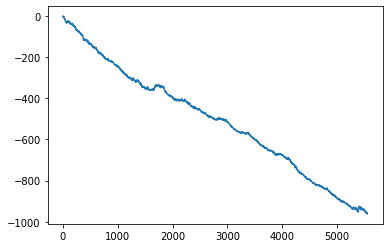

In [ ]:
plt.plot(cum_pnls)

## One run trades with 5 signals

In [ ]:
fee = 0.000002 # 0.002%
delay = 2
quantity = 0.1
horizon = 25
input_window = 100
hfformer = True
num_models = 1

In [ ]:
orderbook_subset = augment_trade_data(orderbook, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',# 'bid10', 'bidqty10',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']#, 'ask10', 'askqty10']

orderbook_subset = orderbook_subset[features]#[:100_000]

In [ ]:
models = []
ids = [id for id in range(horizon-num_models//2, horizon+num_models//2+1)]
# ids = [26,28,30]

for idx in ids:
    if hfformer:
        models.append(torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{idx}.pt'))
    else:
        models.append(torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/LSTM_MO_FINAL_LAG_{idx}.pt'))

Long: quantity 0.1, ask price 22410.60, holdings 0.1


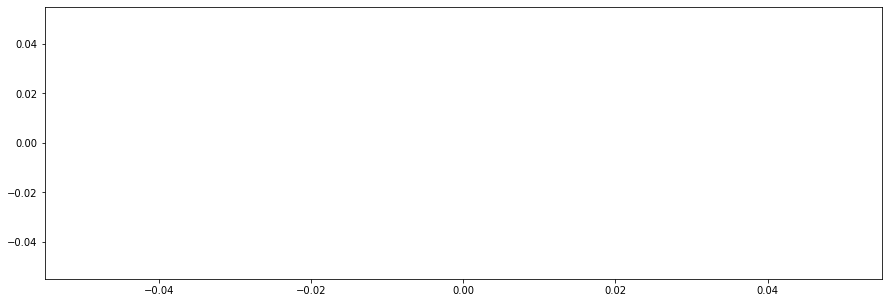

Short: quantity 0.1, bid price 22417.33
PnL: 0.67, Holdings: 0.0


Short: quantity 0.1, bid price 22416.83, holdings -0.1
Long: quantity 0.1, ask price 22409.85
PnL: 0.70, Holdings: 0.0


Short: quantity 0.1, bid price 22409.63, holdings -0.1
Long: quantity 0.1, ask price 22417.29
PnL: -0.77, Holdings: 0.0


Long: quantity 0.1, ask price 22420.77, holdings 0.1
Short: quantity 0.1, bid price 22420.22
PnL: -0.06, Holdings: 0.0


Long: quantity 0.1, ask price 22417.94, holdings 0.1
Short: quantity 0.1, bid price 22422.98
PnL: 0.50, Holdings: 0.0


Long: quantity 0.1, ask price 22428.20, holdings 0.1
Short: quantity 0.1, bid price 22426.35
PnL: -0.19, Holdings: 0.0


Short: quantity 0.1, bid price 22420.69, holdings -0.1
Long: quantity 0.1, ask price 22414.68
PnL: 0.60, Holdings: 0.0


Short: quantity 0.1, bid price 22411.42, holdings -0.1
Long: quantity 0.1, ask price 22405.56
PnL: 0.59, Holdings: 0.0


Short: quantity 0.1, bid price 22413.11, holdings -0.1
Long: quantity 0.1, ask price 2

KeyboardInterrupt: ignored

In [ ]:
notional = 40_000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0

verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []

signals = []

prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)

            if hfformer:
                signals.append(np.array([model(src.float()).detach().cpu().numpy()[0][0] for model in models]))
            else:
                signals.append(np.array([model(src.float()).detach().cpu().numpy()[0] for model in models]))

            trg = trg.detach().cpu().numpy()[0][0][0]

            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0
            # print(f'Signal ratio: {correct_signal_counter/counter}') 

        
            if np.all((signals[-1] > 0)) and holdings == 0:
                holdings += quantity
                notional -= current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings > 0:
                holdings -= quantity
                notional += current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal 
                prev_bid = current_midprice
                trade_pnl = (current_midprice - prev_ask)*quantity - (prev_ask+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_ask+current_midprice)*quantity*fee
                signals_end.append(signal)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}')
                    print(f'PnL: {(current_midprice - prev_ask)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
            

            if np.all((signals[-1] < 0)) and holdings == 0:
                holdings -= quantity
                notional += current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_bid = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings < 0:
                holdings += quantity
                notional -= current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                trade_pnl = (prev_bid - current_midprice)*quantity - (prev_bid+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_bid+current_midprice)*quantity*fee
                signals_end.append(signal)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}')
                    print(f'PnL: {(prev_bid - current_midprice)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
                    
            cum_notionals.append(notional)
                
        if timestep % 100 == 0:
            ax2.plot(cum_pnls)
            plt.show()
        #     print(f'Notional: {notional}')
        #     print(f'PnL: {pnl:.2f}, Quantity: {quantity}')
        #     print(f'Holding: {holdings}')
        #     print(f'Fees: {total_fees:.2f}')

In [ ]:
plt.plot(cum_pnls)

In [ ]:
fileobj = open('./pnl_hfformer_1signals.pkl', 'wb')

pickle.dump(cum_pnls, fileobj)
fileobj.close()

In [ ]:
np.sum(pnls)

115.2301545949668

In [ ]:
with open('/content/pnl_hfformer_7signals.pkl', 'rb') as f:
    pnl_lstm = pickle.load(f)


In [ ]:
len(pnls)

10793

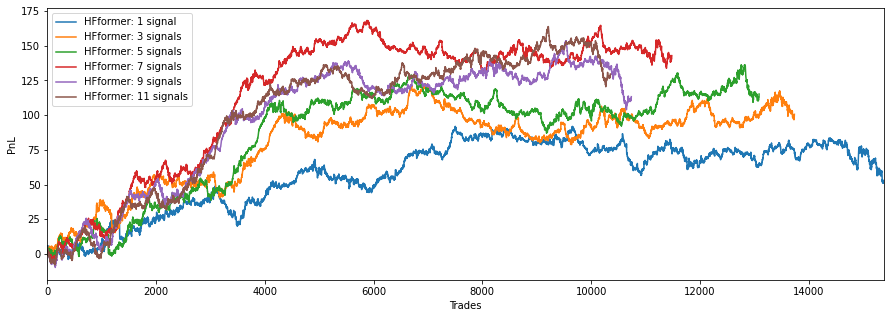

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))

ax2.plot(pickle.load(open('/content/pnl_hfformer_1signals.pkl', 'rb')), label='HFformer: 1 signal')
ax2.plot(pickle.load(open('/content/pnl_hfformer_3signals.pkl', 'rb')), label='HFformer: 3 signals')
ax2.plot(pickle.load(open('/content/pnl_hfformer_5signals.pkl', 'rb')), label='HFformer: 5 signals')
ax2.plot(pickle.load(open('/content/pnl_hfformer_7signals.pkl', 'rb')), label='HFformer: 7 signals')
ax2.plot(pickle.load(open('/content/pnl_hfformer_9signals.pkl', 'rb')), label='HFformer: 9 signals')
ax2.plot(pickle.load(open('/content/pnl_hfformer_11signals.pkl', 'rb')), label='HFformer: 11 signals')

ax2.set_xlabel('Trades')
ax2.set_ylabel('PnL')
ax2.set_xlim(left=0, right=len(pickle.load(open('/content/pnl_hfformer_1signals.pkl', 'rb'))))
ax2.legend(loc='best')

fig2.savefig(f'./pnl_hfformer_different_signals.pdf', dpi=300, bbox_inches='tight')

In [ ]:
signals_num = [1,3,5,7,9,11]
lengths = np.array([len(pickle.load(open(f'/content/pnl_hfformer_{idx}signals.pkl', 'rb'))) for idx in signals_num])
final_pnls = np.array([pickle.load(open(f'/content/pnl_hfformer_{idx}signals.pkl', 'rb'))[-1] for idx in signals_num])

lengths

array([15393, 13740, 13091, 11485, 10741, 10356])

In [ ]:
final_pnls

array([ 52.53026987, 100.59937723, 115.23015459, 142.92030228,
       113.32026068, 129.67366395])

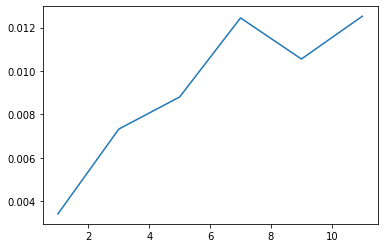

In [ ]:
plt.plot([1,3,5,7,9,11],final_pnls/lengths)

NameError: ignored

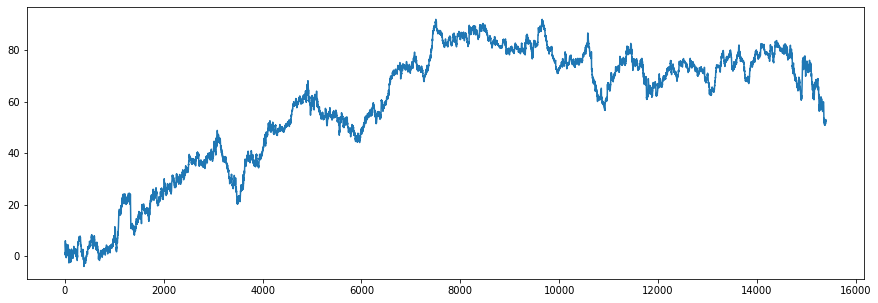

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))
ax2.plot(cum_pnls, label='HFformer')
ax2.plot(pnl_lstm, label='LSTM')


ax2.set_xlabel('Trades')
ax2.set_ylabel('PnL')
# ax2.set_title(f'Log Returns - HFformer - {asset}')
# ax2.set_ylim(bottom=0.3,top=0.9)
ax2.set_xlim(left=0 , right=len(pnl_lstm))
ax2.legend(loc='best')

fig2.savefig(f'./pnl_strategy1_lstm_hfformer.pdf', dpi=300, bbox_inches='tight')

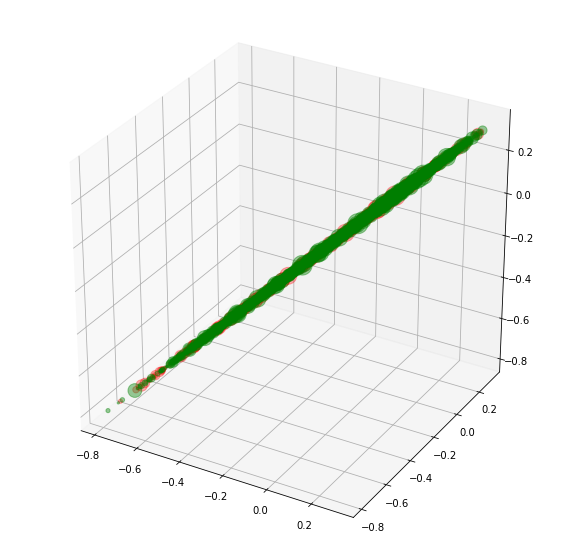

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

signals_1 = np.array(signals_1)[:len(pnls)]
signals_2 = np.array(signals_2)[:len(pnls)]
signals_3 = np.array(signals_3)[:len(pnls)]
pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_2_profit = signals_2[np.array(pnls)>0]
signals_3_profit = signals_3[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_2_loss = signals_2[np.array(pnls)<0]
signals_3_loss = signals_3[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax.scatter(signals_1_profit, signals_2_profit, signals_3_profit, s=np.abs(pnls_profit)*100, color='green', alpha=0.4)
ax.scatter(signals_1_loss, signals_2_loss, signals_3_loss, s=np.abs(pnls_loss)*100, color='red', alpha=0.3)

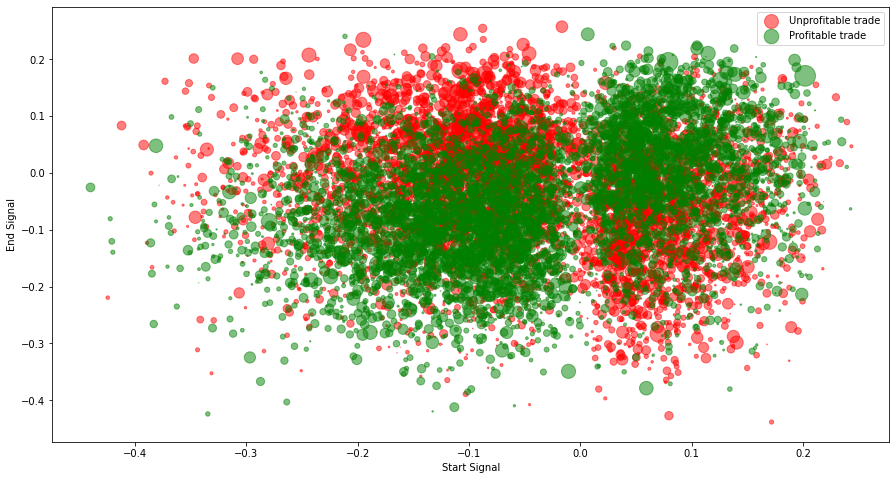

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_start = np.array(signals_start)[:len(pnls)]
signals_end = np.array(signals_end)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_start_profit = signals_start[np.array(pnls)>0]
signals_end_profit = signals_end[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_start_loss = signals_start[np.array(pnls)<0]
signals_end_loss = signals_end[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_start_loss[:len(signals_end_loss)], signals_end_loss[:len(signals_start_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')
ax2.scatter(signals_start_profit[:len(signals_end_profit)], signals_end_profit[:len(signals_start_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')

ax2.set_xlabel('Start Signal')
ax2.set_ylabel('End Signal')
# ax2.set_ylim(bottom=-0.4,top=0.4)
# ax2.set_xlim(left=-0.4,right=0.4)
ax2.legend(loc='best')

# fig2.savefig(f'./trades_cloud_buy_hfformer_1signals.pdf', dpi=300, bbox_inches='tight')

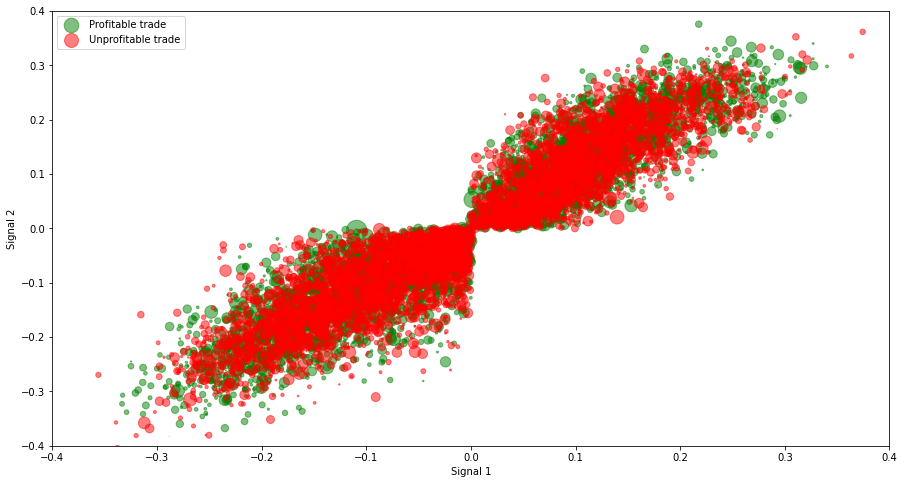

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_1 = np.array(signals_1)[:len(pnls)]
signals_2 = np.array(signals_2)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_2_profit = signals_2[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_2_loss = signals_2[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_1_profit[:len(signals_2_profit)], signals_2_profit[:len(signals_1_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_1_loss[:len(signals_2_loss)], signals_2_loss[:len(signals_1_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Signal 1')
ax2.set_ylabel('Signal 2')
ax2.set_ylim(bottom=-0.4,top=0.4)
ax2.set_xlim(left=-0.4,right=0.4)
ax2.legend(loc='best')


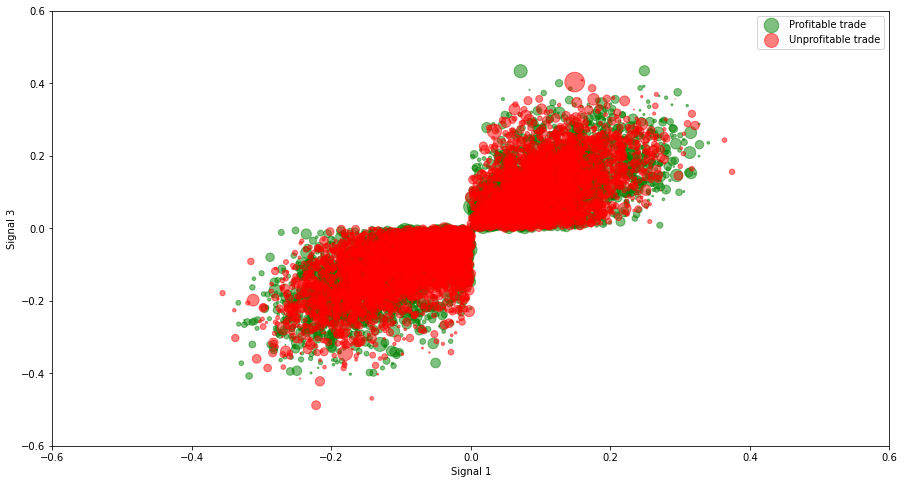

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_1 = np.array(signals_1)[:len(pnls)]
signals_3 = np.array(signals_3)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_3_profit = signals_3[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_3_loss = signals_3[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_1_profit[:len(signals_3_profit)], signals_3_profit[:len(signals_1_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_1_loss[:len(signals_3_loss)], signals_3_loss[:len(signals_1_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Signal 1')
ax2.set_ylabel('Signal 3')
ax2.set_ylim(bottom=-0.6,top=0.6)
ax2.set_xlim(left=-0.6,right=0.6)
ax2.legend(loc='best')

In [ ]:
signals_df = pd.DataFrame({'pnl':pnls, 'signal1':signals_1, 'signal2':signals_2, 'signal3':signals_3, 'signal4':signals_4, 'signal5':signals_5 })

In [ ]:
signals_df.corr()

,pnl,signal1,signal2,signal3,signal4,signal5
pnl,1.000000,0.007214,0.011843,0.008985,0.007163,0.010961
signal1,0.007214,1.000000,0.971106,0.974401,0.957233,0.965258
signal2,0.011843,0.971106,1.000000,0.972183,0.956653,0.968503
signal3,0.008985,0.974401,0.972183,1.000000,0.953691,0.964354
signal4,0.007163,0.957233,0.956653,0.953691,1.000000,0.955223
signal5,0.010961,0.965258,0.968503,0.964354,0.955223,1.000000


## One run trades with +2/-2 horizon indicators

In [ ]:
fee = 0.000001 #0.000005 # 0.005%
delay = 2
quantity = 0.1
horizon = 28
input_window = 100

In [ ]:
orderbook_subset = augment_trade_data(orderbook, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

orderbook_subset = orderbook_subset[features]

In [ ]:
model = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon}.pt')
model2 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon+2}.pt')
model3 = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/transformer_enclinear_forecasting_horizon_{horizon-2}.pt')

In [ ]:
notional = 40_000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
returns = []
total_fees = 0

verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float())
            signal_secondary = model2(src.float())
            signal_tertiary = model3(src.float())
            signal = signal.detach().cpu().numpy()[0][0]
            signal_secondary = signal_secondary.detach().cpu().numpy()[0][0]
            signal_tertiary = signal_tertiary.detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]

            if verbose:
                None
                print(f'signal {signal:.3f}, secondary signal {signal_secondary:.3f} tertiary signal {signal_tertiary:.3f}, trg {trg:.3f}')
                print(f'signal {signal:.3f}, return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                print(f'signal {signal:.3f}, return long {np.log(future_bid/current_ask_price)*10_000:.3f}')


            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0
            # print(f'Signal ratio: {correct_signal_counter/counter}') 

        
            if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and holdings == 0:
                print(timestep)
                holdings += quantity
                notional -= current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings > 0:
                print(timestep)
                holdings -= quantity
                notional += current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal 
                prev_bid = current_midprice
                trade_pnl = (current_midprice - prev_ask)*quantity - (prev_ask+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_ask+current_midprice)*quantity*fee
                signals_end.append(signal)
                returns.append((current_midprice - prev_ask)/prev_ask)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}')
                    print(f'PnL: {(current_midprice - prev_ask)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
            

            if signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and holdings == 0:
                holdings -= quantity
                notional += current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_bid = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings < 0:
                holdings += quantity
                notional -= current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                trade_pnl = (prev_bid - current_midprice)*quantity - (prev_bid+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_bid+current_midprice)*quantity*fee
                signals_end.append(signal)
                returns.append((prev_bid - current_midprice)/prev_bid)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}')
                    print(f'PnL: {(prev_bid - current_midprice)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
                    
            cum_notionals.append(notional)
                
        # if timestep % 100 == 0:
        #     print(f'Notional: {notional}')
        #     print(f'PnL: {pnl:.2f}, Quantity: {quantity}')
        #     print(f'Holding: {holdings}')
        #     print(f'Fees: {total_fees:.2f}')

Streaming output truncated to the last 5000 lines.
signal 0.064, return short 2.307
signal 0.064, return long 0.730
433020
Long: quantity 0.1, ask price 22887.40, holdings 0.1
signal 0.042, secondary signal 0.081 tertiary signal 0.021, trg -1.482
signal 0.042, return short -1.236
signal 0.042, return long -1.743
433048
Short: quantity 0.1, bid price 22891.08
PnL: 0.37, Holdings: 0.0


signal -0.069, secondary signal -0.155 tertiary signal -0.071, trg 0.245
signal -0.069, return short 0.638
signal -0.069, return long -0.031
Short: quantity 0.1, bid price 22887.94, holdings -0.1
signal -0.009, secondary signal -0.113 tertiary signal -0.089, trg 0.365
signal -0.009, return short 1.131
signal -0.009, return long -0.039
Long: quantity 0.1, ask price 22891.39
PnL: -0.34, Holdings: 0.0


signal -0.148, secondary signal -0.005 tertiary signal 0.010, trg -0.264
signal -0.148, return short 0.301
signal -0.148, return long -0.799
signal 0.020, secondary signal -0.049 tertiary signal 0.015, trg 2.

KeyboardInterrupt: ignored

In [ ]:
print(f'mean {np.mean(pnls)}')
print(f'median {np.median(pnls)}')
print(f'std {np.std(pnls)}')
print(f'max {np.max(pnls)}')
print(f'min {np.min(pnls)}')

mean 0.02041731511200877
median 0.011378656279339339
std 0.5067337804358022
max 4.815735513931941
min -4.45933371072315


(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 4.000e+00, 8.000e+00, 5.000e+00, 1.200e+01, 2.300e+01,
        4.300e+01, 7.300e+01, 1.330e+02, 3.050e+02, 5.820e+02, 1.188e+03,
        2.583e+03, 3.255e+03, 1.762e+03, 8.890e+02, 5.080e+02, 2.380e+02,
        1.140e+02, 6.800e+01, 3.500e+01, 1.800e+01, 1.600e+01, 8.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-4.45933371, -4.22745698, -3.99558025, -3.76370352, -3.53182679,
        -3.29995006, -3.06807333, -2.8361966 , -2.60431987, -2.37244314,
        -2.1405664 , -1.90868967, -1.67681294, -1.44493621, -1.21305948,
        -0.98118275, -0.74930602, -0.51742929, -0.28555256, -0.05367583,
         0.1782009 ,  0.41007763,  0.64195436,  0.87383109,  1.10570782,
         1.33758455,  1.56946129,  1.80133802,  2.03321475,  2.26509148,
         2.49696821,  2.72884494,  2.96072167,  3.1925984 ,  3.4

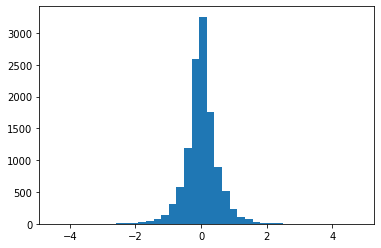

In [ ]:
plt.hist(pnls, bins=40)

In [ ]:
share_ratio = np.mean(returns)/np.std(returns)
print(share_ratio)

0.040350681273831526


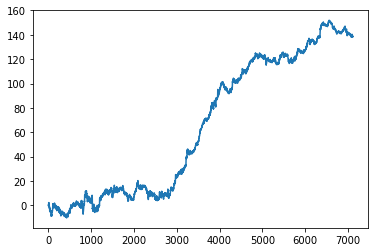

In [ ]:
plt.plot(cum_pnls)

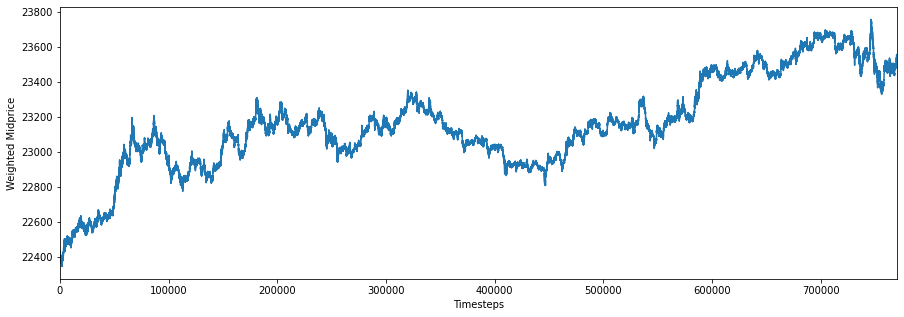

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))

ax2.plot(orderbook['price'])

ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Weighted Midprice')
ax2.set_xlim(left=0,right=len(orderbook))

fig2.savefig(f'./midprice_backtest.pdf', dpi=300, bbox_inches='tight')

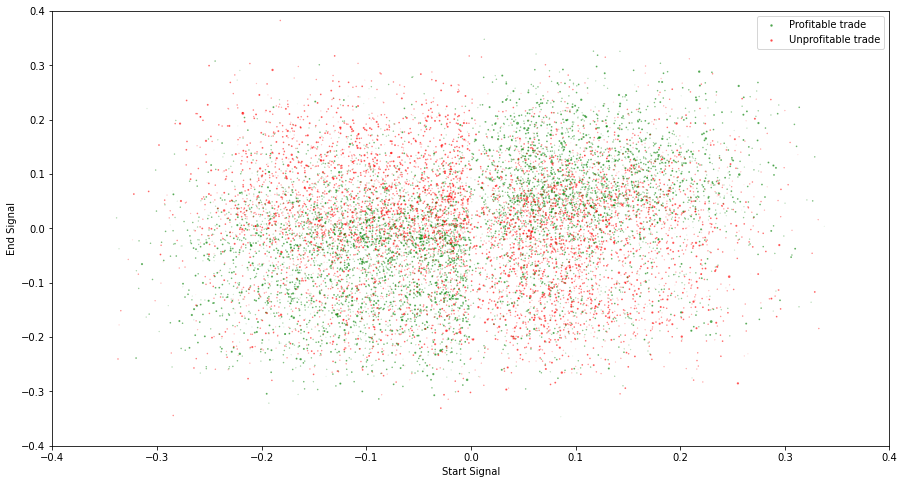

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_start = np.array(signals_start)[:len(pnls)]
signals_end = np.array(signals_end)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_start_profit = signals_start[np.array(pnls)>0]
signals_end_profit = signals_end[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_start_loss = signals_start[np.array(pnls)<0]
signals_end_loss = signals_end[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_start_profit[:len(signals_end_profit)], signals_end_profit[:len(signals_start_profit)], s=np.abs(pnls_profit), alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_start_loss[:len(signals_end_loss)], signals_end_loss[:len(signals_start_loss)], s=np.abs(pnls_loss), alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Start Signal')
ax2.set_ylabel('End Signal')
ax2.set_ylim(bottom=-0.4,top=0.4)
ax2.set_xlim(left=-0.4,right=0.4)
ax2.legend(loc='best')

fig2.savefig(f'./trades_cloud_buy_window2.pdf', dpi=300, bbox_inches='tight')